## Setup

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax.experimental.ode import odeint

In [2]:
def a(t):
    return jnp.exp(-t)


def b(t):
    return jnp.sqrt(1 - jnp.exp(-2 * t))


def p_btxi_grad(x, t):
    # Expects x to be shape (1, d).
    sigma_sq = b(t) ** 2
    return -1/sigma_sq * jnp.exp(-(x ** 2).sum(axis=1, keepdims=1)/(2 * sigma_sq)) * x


def p_btxi(x, t):
    # Expects x to be shape (1, d).
    sigma_sq = b(t) ** 2
    return jnp.exp(-(x ** 2).sum(axis=1, keepdims=1)/(2 * sigma_sq))

## Data Distributions

In [3]:
sep_scale = 1
k = 2

In [4]:
def uniform_square(key, score_samples, t):
    key, xy_key = random.split(key, 2)
    xy = a(t) * random.uniform(xy_key, shape=(score_samples, 2), minval=-0.5, maxval=0.5)
    return key, xy

In [5]:
def shifted_uniform_square(key, score_samples, t, y):
    key, xy = uniform_square(key, score_samples, t)
    shift = jnp.hstack((jnp.ones(shape=(score_samples, 1)),
                       jnp.zeros(shape=(score_samples, 1))))
    return key, xy + a(t) * sep_scale * (2 * y - 1) * shift

In [6]:
def shifted_uniform_square_marginal(key, score_samples, t):
    key, c_key = random.split(key)
    y = random.randint(c_key, shape=(score_samples, 1), minval=0, maxval=k)
    return shifted_uniform_square(key, score_samples, t, y)

In [38]:
def gaussian(key, score_samples, t):
    key, xy_key = random.split(key, 2)
    xy = a(t) * random.normal(xy_key, shape=(score_samples, 2))*3
    return key, xy

In [63]:
def shifted_gaussian(key, score_samples, t, y):
    key, xy = gaussian(key, score_samples, t)
    shift = jnp.hstack((jnp.ones(shape=(score_samples, 1)),
                       jnp.zeros(shape=(score_samples, 1))))*3
    return key, xy + a(t) * sep_scale * (2 * y - 1) * shift

In [64]:
def shifted_gaussian_marginal(key, score_samples, t):
    key, c_key = random.split(key)
    y = random.randint(c_key, shape=(score_samples, 1), minval=0, maxval=k)
    return shifted_gaussian(key, score_samples, t, y)

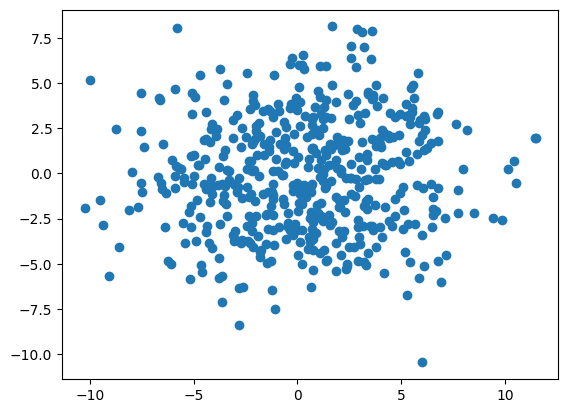

In [65]:
key = jax.random.key(0)
key, marginal_samples = shifted_gaussian_marginal(key, 500, 0)
plt.scatter(marginal_samples[:,0], marginal_samples[:,1])

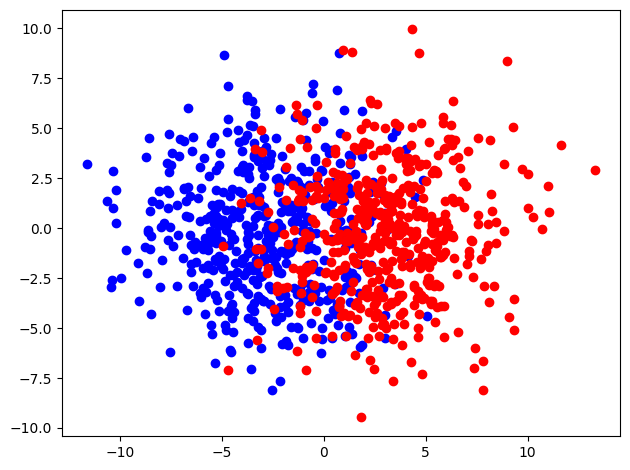

In [66]:
key, left_samples = shifted_gaussian(key, 500, 0, y=0)
key, right_samples = shifted_gaussian(key, 500, 0, y=1)

plt.scatter(left_samples[:,0], left_samples[:,1], color="blue")
plt.scatter(right_samples[:,0], right_samples[:,1], color="red")
plt.tight_layout()
# plt.savefig("synthetic_plots/two_gaussians.jpg")

In [67]:
global_score_samples = 500
global_uncond_sampler = shifted_gaussian_marginal
global_cond_sampler = shifted_gaussian
global_T = 5
global_delta = 5e-3
global_ts = jnp.linspace(0, global_T, int(global_T/global_delta))[:-1]

## Diffusion Utils

In [68]:
def uncond_score(key, sampler, x, score_samples, t):
    key, num = sampler(key, score_samples, t)
    key, den = sampler(key, score_samples, t)
    return key, p_btxi_grad(x - num, t).mean(axis=0) / p_btxi(x - den, t).mean(axis=0)

In [69]:
def cond_score(key, sampler, x, score_samples, t, y):
    key, num = sampler(key, score_samples, t, y)
    key, den = sampler(key, score_samples, t, y)
    return key, p_btxi_grad(x - num, t).mean(axis=0) / p_btxi(x - den, t).mean(axis=0)

In [70]:
def uncond_ode(key, sampler, x, score_samples, t):
    key, score = uncond_score(key, sampler, x, score_samples, t)
    return key, x + score

def partial_uncond_ode(x, t, key):
    key, ode_key = random.split(key)
    ode_key, next = uncond_ode(key=ode_key,
                               sampler=global_uncond_sampler,
                               x=x,
                               score_samples=global_score_samples,
                               t=global_T-t)
    return next

def diffuse_uncond(key, x):
    key, diffuse_key = random.split(key)
    return key, odeint(partial_uncond_ode, x, global_ts, diffuse_key, mxstep=25)

v_diffuse_uncond = jax.vmap(diffuse_uncond)

In [71]:
def guided_ode(key, uncond_sampler, cond_sampler, x, score_samples, t, y, w):
    key, uncond = uncond_score(key, uncond_sampler, x, score_samples, t)
    key, cond = cond_score(key, cond_sampler, x, score_samples, t, y)
    guided_score = (1 + w) * cond - w * uncond
    return key, x + guided_score

def partial_guided_ode(x, t, key, y, w):
    key, ode_key = random.split(key)
    ode_key, next = guided_ode(key=key, 
                               uncond_sampler=global_uncond_sampler, 
                               cond_sampler=global_cond_sampler, 
                               x=x, 
                               score_samples=global_score_samples, 
                               t=global_T-t, 
                               y=y, 
                               w=w)
    return next

def diffuse_cond(key, x, y, w):
    key, diffuse_key = random.split(key)
    return key, odeint(partial_guided_ode, x, global_ts, diffuse_key, y, w, mxstep=25)

v_diffuse_cond = jax.vmap(diffuse_cond)

## Generate Unconditional Samples

In [52]:
n_sample = 100
key, x_key = random.split(key)
x = random.normal(x_key, shape=(n_sample, 2))
key, *all_keys = random.split(key, n_sample + 1)
_, trajs = v_diffuse_uncond(jnp.array(all_keys), x)

## Generate Conditional Samples

In [73]:
def conditional_sample(key, y, w):
    n_sample = 100
    key, x_key = random.split(key)
    x = random.normal(x_key, shape=(n_sample, 2))
    key, *all_keys = random.split(key, n_sample + 1)
    _, trajs = v_diffuse_cond(jnp.array(all_keys),
                              x, 
                              y * jnp.ones(shape=(n_sample,)), 
                              w * jnp.ones(shape=(n_sample,)))
    return key, trajs

In [ ]:
key, cond_trajs = conditional_sample(key, y=1, w=0)

In [56]:
key, guide_trajs = conditional_sample(key, y=1, w=3)

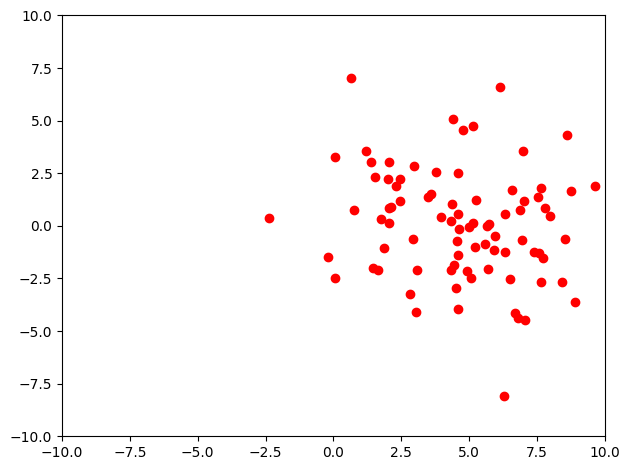

In [ ]:
plt.scatter(cond_trajs[:, -1, 0], cond_trajs[:, -1, 1], color="red")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()
# plt.savefig("synthetic_plots/right_gaussian.jpg")

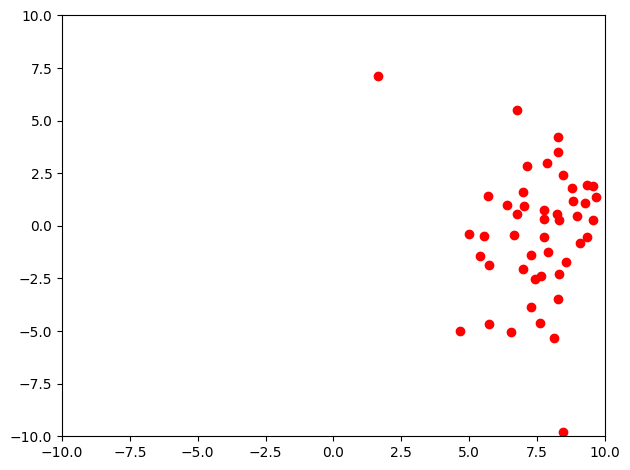

In [72]:
plt.scatter(guide_trajs[:, -1, 0], guide_trajs[:, -1, 1], color="red")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()
# plt.savefig("synthetic_plots/right_gaussian_guided.jpg")

## Analyze Trajectories

In [31]:
def filter_good_inds(trajs, y):
    # x_min, x_max = -0.5 + sep_scale * (2 * y - 1), 0.5 + sep_scale * (2 * y - 1)
    # y_min, y_max = -0.5, 0.5
    
    # samples = trajs[:, -1]
    
    # valid_xs = jnp.logical_and(samples[:, 0] >= x_min, samples[:, 0] <= x_max)
    # valid_ys = jnp.logical_and(samples[:, 1] >= y_min, samples[:, 1] <= y_max)
    # valid_both = jnp.logical_and(valid_xs, valid_ys)
    
    # good_inds = jnp.logical_and(~(jnp.isnan(samples)).any(axis=1), valid_both)
    samples = trajs[:, -1]
    return ~(jnp.isnan(trajs.reshape(trajs.shape[0], -1)).any(axis=1))
    # return jnp.logical_and(~(jnp.isnan(trajs.reshape(trajs.shape[0], -1)).any(axis=1)), ~((jnp.abs(trajs.reshape(trajs.shape[0], -1)) > 1000).any(axis=1)))

In [32]:
y = 1
w_vals = [1, 3, 7, 15]
all_guide_trajs = []
for w in w_vals:
    key, guide_trajs = conditional_sample(key, y=y, w=w)
    all_guide_trajs.append(guide_trajs)

In [33]:
all_good_inds = [filter_good_inds(traj, y) for traj in all_guide_trajs]
all_samples = [traj[:, -1] for traj in all_guide_trajs]

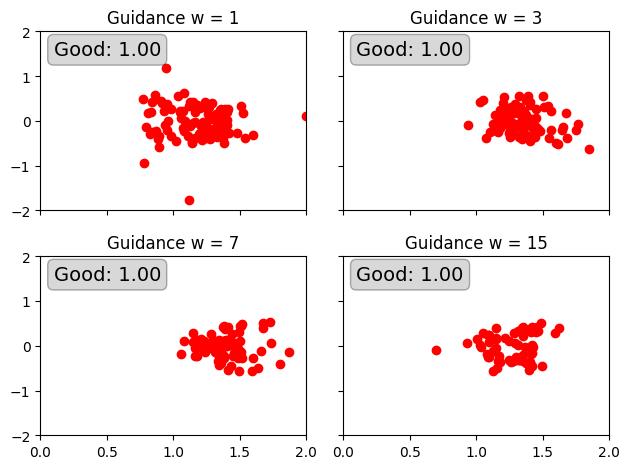

In [37]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i, w in enumerate(w_vals):
    row, col = i // 2, i % 2
    samples = all_samples[i]
    axs[row, col].scatter(samples[:, 0], samples[:, 1], color="red")
    axs[row, col].set_title(f"Guidance w = {w}")

    support_frac = all_good_inds[i].sum() / len(samples)
    props = dict(boxstyle='round', facecolor='gray', alpha=0.3)
    axs[row, col].text(0.05, 
                       0.95, 
                       f"Good: {support_frac:.2f}", 
                       transform=axs[row, col].transAxes, 
                       fontsize=14,
                       verticalalignment='top', 
                       bbox=props)
plt.xlim(0, 2)
plt.ylim(-2, 2)
plt.tight_layout()
# plt.savefig("synthetic_plots/gaussian_guidance_grid.jpg")
plt.show()

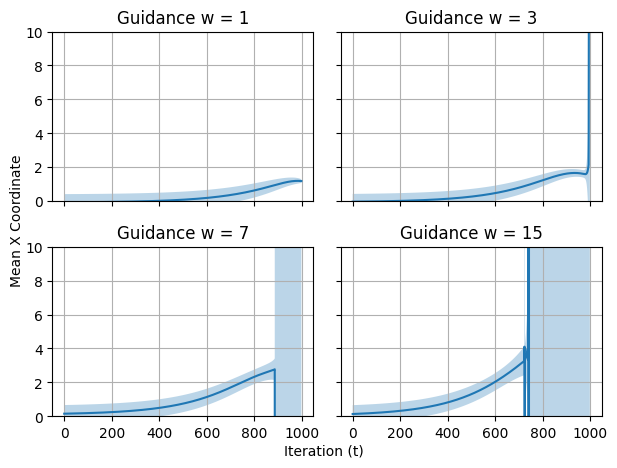

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i, w in enumerate(w_vals):
    row, col = i // 2, i % 2
    good_trajs = all_guide_trajs[i][all_good_inds[i]]
    # good_trajs = all_guide_trajs[i]
    
    normal_vec = jnp.array([1, 0])
    proj_trajs = good_trajs @ normal_vec

    mean_traj = proj_trajs.mean(axis=0)
    traj_std = proj_trajs.std(axis=0)
    
    axs[row, col].plot(jnp.arange(mean_traj.shape[0]), mean_traj)
    axs[row, col].fill_between(jnp.arange(mean_traj.shape[0]), 
                               mean_traj + traj_std / 2, 
                               mean_traj - traj_std / 2, 
                               alpha=0.3)
    axs[row, col].grid()
    axs[row, col].set_title(f"Guidance w = {w}")

plt.ylim(0, 10)
fig.text(0.53, 0.04, 'Iteration (t)', ha='center')
fig.text(0.04, 0.53, 'Mean X Coordinate', va='center', rotation='vertical')
plt.tight_layout(rect=[0.04, 0.04, 1, 1])
# plt.savefig("synthetic_plots/gaussian_trajectory_grid.jpg")
plt.show()